# Inertia Gravity Wave Convergence Test

simulating a coastal kelvin wave

In [2]:
CODE_ROOT = pwd() * "/"

"/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/"

In [3]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")
include(CODE_ROOT * "mode_init/exactsolutions.jl")

using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()
import Dates
using DelimitedFiles

In [4]:
function inertiagravity_test(mesh_directory, base_mesh_file_name, mesh_file_name, T, dt, nx=2, ny=2, etaHat=1e0;
        plot=false, nvlevels=1)
    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name, periodicity="Periodic", nvlevels=nvlevels)
#     fixAngleEdge2!(mpasOcean)
    
    etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasOcean, nx, ny, etaHat)
    
    println("setting up initial condition")
    inertiaGravityExactSolution!(mpasOcean, etaHat, f0, kX, kY, omega, 0.0)
    
    
    println("original dt $(mpasOcean.dt)")
    nSteps = Int(round(T/mpasOcean.dt))
    mpasOcean.dt = T / nSteps
    println("adjusted dt $(mpasOcean.dt)")
    println("nSteps $nSteps")
    
    nSaves=1
    sshOverTimeNumerical = zeros(Float64, (nSaves, mpasOcean.nCells))
    sshOverTimeExact = zeros(Float64, (nSaves, mpasOcean.nCells))
    nvOverTimeExact = zeros(Float64, (nSaves, mpasOcean.nEdges))
    
#     println("dx $(mpasOcean.dcEdge[1]) \t dt $(mpasOcean.dt) \t dx/c $(maximum(mpasOcean.dcEdge) / c) \t dx/dt $(mpasOcean.dcEdge[1]/mpasOcean.dt)")
#     println("period $period \t steps $nSteps")
    
    
    println("simulating for T: $T")
    t = 0
    for i in 1:nSaves
        for j in 1:nSteps
            
            calculate_normal_velocity_tendency!(mpasOcean)
            update_normal_velocity_by_tendency!(mpasOcean)
            
            calculate_thickness_tendency!(mpasOcean)
            update_thickness_by_tendency!(mpasOcean)
            
            t += mpasOcean.dt
        end
        mpasOcean.sshCurrent = dropdims(sum(mpasOcean.layerThickness, dims=1),dims=1) - mpasOcean.bottomDepth
        sshOverTimeNumerical[i,:] .= mpasOcean.sshCurrent[:]
    end
    
    for iCell = 1:mpasOcean.nCells
        sshOverTimeExact[1,iCell] = DetermineInertiaGravityWaveExactSurfaceElevation(etaHat,kX,kY,omega,mpasOcean.xCell[iCell],mpasOcean.yCell[iCell],t)
    end
    for iEdge in 1:mpasOcean.nEdges
        nvOverTimeExact[1,iEdge] = inertiaGravityExactNormalVelocity(mpasOcean.angleEdge[iEdge],etaHat,f0, mpasOcean.gravity, kX,kY,omega,mpasOcean.xEdge[iEdge],mpasOcean.yEdge[iEdge], t)
    end
    
    if plot
        
        fig, axs = plt.subplots(2,3)
        
        _, ax, cbar1 = heatMapMesh(mpasOcean, mpasOcean.sshCurrent, fig=fig, ax=axs[1,1])
        ax.set_title("Numerical Solution")

        _, ax, cbar2 = heatMapMesh(mpasOcean, sshOverTimeExact[end,:], fig=fig, ax=axs[1,2])
        ax.set_title("Exact Solution")
        
        _, ax, _ = heatMapMesh(mpasOcean, sshOverTimeExact[end,:] - sshOverTimeNumerical[end,:], fig=fig, ax=axs[1,3])#, cMin=-0.005, cMax=0.005)
        ax.set_title("Difference")
        
        for cbar in (cbar1, cbar2)
            cbar.formatter.set_useMathText(true)
            cbar.formatter.set_scientific(true)
            cbar.update_ticks()
        end
        
#         _, ax, _ = edgeHeatMapMesh(mpasOcean, mpasOcean.normalVelocityCurrent, fig=fig, ax=axs[2,1])
#         ax.set_title("Numerical Solution")

#         _, ax, _ = edgeHeatMapMesh(mpasOcean, nvOverTimeExact[end,:], fig=fig, ax=axs[2,2])
#         ax.set_title("Exact Solution")
        
#         _, ax, _ = edgeHeatMapMesh(mpasOcean, nvOverTimeExact[end,:] - mpasOcean.normalVelocityCurrent[:,1], fig=fig, ax=axs[2,3])
#         ax.set_title("Difference")
        
        fig.tight_layout()
        
        display(fig)
    end
    
    error = sshOverTimeNumerical .- sshOverTimeExact
    MaxErrorNorm = norm(error, Inf)
    L2ErrorNorm = norm(error/sqrt(float(mpasOcean.nCells)))
    
    return mpasOcean.nCells, mpasOcean.dt, MaxErrorNorm, L2ErrorNorm
end

inertiagravity_test (generic function with 4 methods)

setting up initial condition
original dt 404.0610178208778
adjusted dt 400.0
nSteps 5
simulating for T: 2000


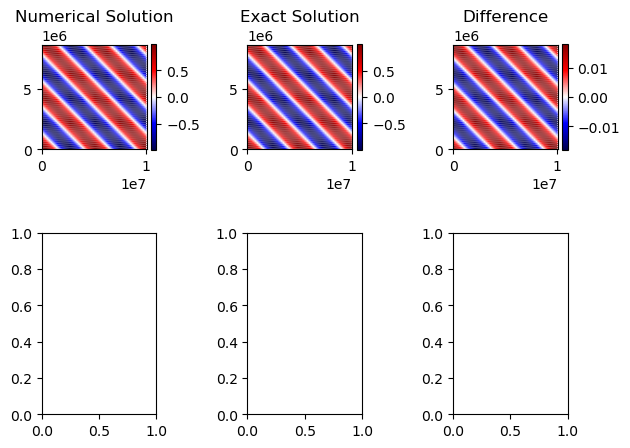

(10000, 400.0, 0.01806101846362007, 0.012647498926504139)

In [46]:
T = 2000
nCellsX = 64
etaHat = 1e0
nCells, dt, MaxErrorNorm, L2ErrorNorm = inertiagravity_test(
    CODE_ROOT * "InertiaGravityWaveMesh",
    "base_mesh.nc", "mesh.nc", T, 75, 2, 2, etaHat, plot=true, nvlevels=1)

In [47]:
MaxErrorNorm/etaHat

0.01806101846362007

In [15]:
MaxErrorNorm/etaHat

0.012062296514970854

In [48]:
# function wrap_regex(str::AbstractString, maxlen = 92)
#     replace(str, Regex(".{1,$maxlen}( |\$)") => @s_str "\\0\n")
# end

function convergenceplot(nCellsX, errorNorm, normtype, decimals)
    A = [log10.(nCellsX)    ones(length(nCellsX))]
    m, c = A \ log10.(errorNorm)
    y = m*log10.(nCellsX) .+ c
    y = 10 .^ y
    
    slopestr ="$(round(m,digits=decimals))"
    while length(split(slopestr, ".")[end]) < decimals
        slopestr *= "0"
    end
    Tstr ="$(round(T,digits=decimals))"
    while length(split(Tstr, ".")[end]) < decimals
        slopestr *= "0"
    end
    
    fig, ax = subplots(1,1, figsize=(9,9))
    tight_layout()
    loglog(nCellsX, errorNorm, label="$normtype error norm", marker="s", markersize=12.5, linestyle="None", color="black")
    loglog(nCellsX, y, label="Best fit line, slope=$slopestr", color="black", linewidth=2)
    ax.set_title("Convergence of Inertia Gravity Wave \nRefinement in Space and Time",
        fontsize=30, fontweight="bold", y=1.035)
    ax.legend(loc="upper right", fontsize=22.5)
    ax.set_xlabel("Number of cells in zonal direction", fontsize=25, labelpad=7.5)
    ax.set_ylabel("$normtype error norm of SSH", fontsize=25, labelpad=7.5)
    ax.tick_params(axis="both", which="both", labelsize=20)
    
    grid(which="both")
    
    return fig, ax
end

convergenceplot (generic function with 1 method)

In [49]:
function convergence_test(periodicity, mesh_directory, operator_name, test, device, horizonscale = 32;
                write_data=false, show_plots=true, decimals=2, resolutions=[64, 128, 256, 512],
                format=(x->string(x)), nvlevels=1)
    nCases = length(resolutions)
    nCellsX = collect(Int.(round.(resolutions)))
    ncells = zeros(Float64, nCases)
    dts = zeros(Float64, nCases)
    MaxErrorNorm = zeros(Float64, nCases)
    L2ErrorNorm = zeros(Float64, nCases)
    
    # calculate maximum dt
    iCase = argmin(resolutions)
    if periodicity == "Periodic"
        base_mesh_file_name = "base_mesh_$(format(nCellsX[iCase])).nc"
    else
        base_mesh_file_name = "culled_mesh_$(format(nCellsX[iCase])).nc"
    end
    mesh_file_name = "mesh_$(format(nCellsX[iCase])).nc"
    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name, periodicity=periodicity, nvlevels=nvlevels)
    
    maxdt = mpasOcean.dt
    T = horizonscale*maxdt
    
    for iCase = 1:nCases
        if periodicity == "Periodic"
            base_mesh_file_name = "base_mesh_$(format(nCellsX[iCase])).nc"
        else
            base_mesh_file_name = "culled_mesh_$(format(nCellsX[iCase])).nc"
        end
        mesh_file_name = "mesh_$(format(nCellsX[iCase])).nc"
        println()
        println("running test $iCase of $nCases, mesh: $mesh_file_name")
        etaHat = 1e0
        ncells[iCase], dts[iCase], MaxErrorNorm[iCase], L2ErrorNorm[iCase] =
                test(mesh_directory, base_mesh_file_name, mesh_file_name, T, maxdt, 2, 2, etaHat;
                        plot=false, nvlevels=nvlevels)
        println("max error norm / wave amplitude: $(MaxErrorNorm[iCase]/etaHat)")
        println("L2 error norm / wave amplitude: $(L2ErrorNorm[iCase]/etaHat)")
    end
    
    nCellsX = sqrt.(ncells)
    
    A = [log10.(nCellsX)    ones(length(nCellsX))]
    mmax, cmax = A \ log10.(MaxErrorNorm)
    ymax = mmax*log10.(nCellsX) .+ cmax
    ymax = 10 .^ ymax
    
    
    A = [log10.(nCellsX)    ones(length(nCellsX))]
    ml2, cl2 = A \ log10.(L2ErrorNorm)
    yl2 = ml2*log10.(nCellsX) .+ cl2
    yl2 = 10 .^ yl2
    
    if write_data
        fpath = CODE_ROOT * "output/simulation_convergence/inertiagravitywave/$periodicity/$device/timehorizon_$(T)/"
        mkpath(fpath)
        fname = "$fpath$(Dates.now()).txt"
        open(fname, "w") do io
            writedlm(io, [ncells, dts, L2ErrorNorm, MaxErrorNorm])
        end
        println("saved to $fname")
    end
    
    if show_plots
        convergenceplot(nCellsX, MaxErrorNorm, "Maximum", T, 2)
        
        convergenceplot(nCellsX, L2ErrorNorm, "\$L^2\$", T, 2)
    end
end

convergence_test (generic function with 2 methods)

In [50]:
convergence_test("Periodic",
            CODE_ROOT * "/InertiaGravityWaveMesh/ConvergenceStudyMeshes",
            "InertiaGravityWave",
            inertiagravity_test, "CPU",
            32,
            resolutions=[64, 96, 144, 216, 324],
            format=(x->"$(x)x$(x)"),
            write_data=true, show_plots=false, nvlevels=1)


running test 1 of 5, mesh: mesh_64x64.nc
setting up initial condition
original dt 631.3453403451269
adjusted dt 631.3453403451269
nSteps 32
simulating for T: 20203.050891044062
max error norm / wave amplitude: 0.10572175558342689
L2 error norm / wave amplitude: 0.07333933952720142

running test 2 of 5, mesh: mesh_96x96.nc
setting up initial condition
original dt 420.89689356476254
adjusted dt 420.89689356341796
nSteps 48
simulating for T: 20203.050891044062
max error norm / wave amplitude: 0.0732412750062803
L2 error norm / wave amplitude: 0.05047724597012105

running test 3 of 5, mesh: mesh_144x144.nc
setting up initial condition
original dt 280.59792904047316
adjusted dt 280.5979290422786
nSteps 72
simulating for T: 20203.050891044062
max error norm / wave amplitude: 0.05033922582865713
L2 error norm / wave amplitude: 0.03432368519542117

running test 4 of 5, mesh: mesh_216x216.nc
setting up initial condition
original dt 187.0652860269808
adjusted dt 187.06528602818577
nSteps 108
si

In [51]:
function readconvergencefile(periodicity, device, T)
    fname = CODE_ROOT * "output/simulation_convergence/inertiagravitywave/$periodicity/$device/timehorizon_$(T)/"
    fname = filter(x->x[end-3:end] == ".txt", readdir(fname, join=true))[end]
    return readdlm(fname), fname
end

readconvergencefile (generic function with 1 method)

In [52]:
T = 20203.050891044062
data, fname = readconvergencefile("Periodic", "CPU", T)
data[1,:], data[3]

([4096.0, 9216.0, 20736.0, 46656.0, 104976.0], 0.07333933952720142)

In [53]:
fname

"/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/simulation_convergence/inertiagravitywave/Periodic/CPU/timehorizon_20203.050891044062/2022-12-22T16:28:49.859.txt"

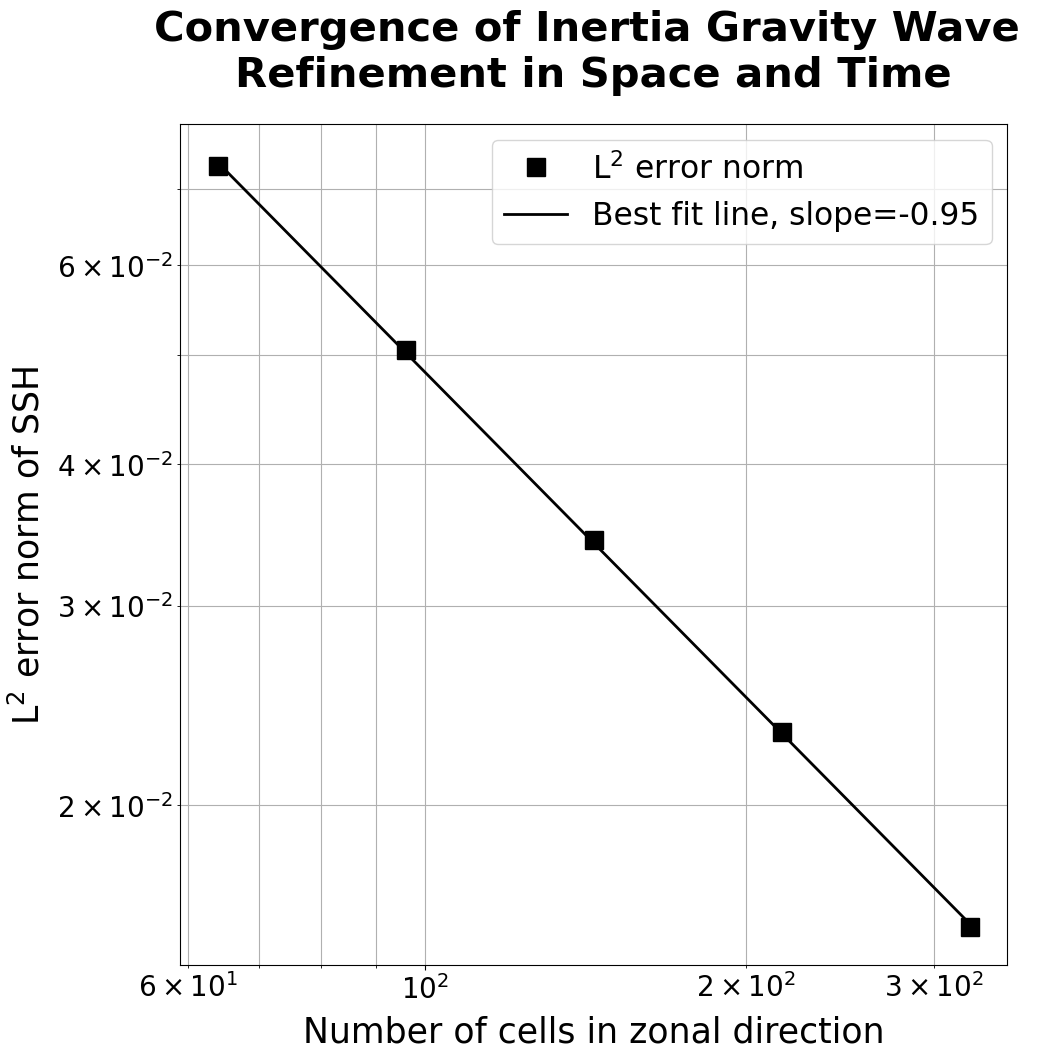

In [54]:
fig, ax = convergenceplot(sqrt.(data[1,:]), data[3,:], "L\$^2\$", 2)
fig.savefig("$(fname)_convergence.pdf", bbox_inches="tight")

In [5]:
mpasOcean = MPAS_Ocean(CODE_ROOT * "InertiaGravityWaveMesh",
    "base_mesh.nc", "mesh.nc", periodicity="Periodic")
mpasOcean.nCells

10000

In [6]:
etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasOcean, 2, 2, 1e0)
inertiaGravityExactSolution!(mpasOcean, etaHat, f0, kX, kY, omega, 0.0)

In [7]:
function hoursminssecs(T)
    hours = floor(T/3600)
    T -= 3600*hours
    mins = floor(T/60)
    T -= 60*mins
    return hours, mins, T
end

hoursminssecs (generic function with 1 method)

In [8]:
nSteps = 100
for i in 1:nSteps
    forward_backward_step!(mpasOcean)
end
mpasOcean.sshCurrent = dropdims(sum(mpasOcean.layerThickness,dims=1),dims=1) - mpasOcean.bottomDepth
hours, mins, secs = hoursminssecs(100*mpasOcean.dt)
println("simulated $hours hours, $mins minutes, and $secs seconds")

simulated 11.0 hours, 13.0 minutes, and 26.10178208778234 seconds


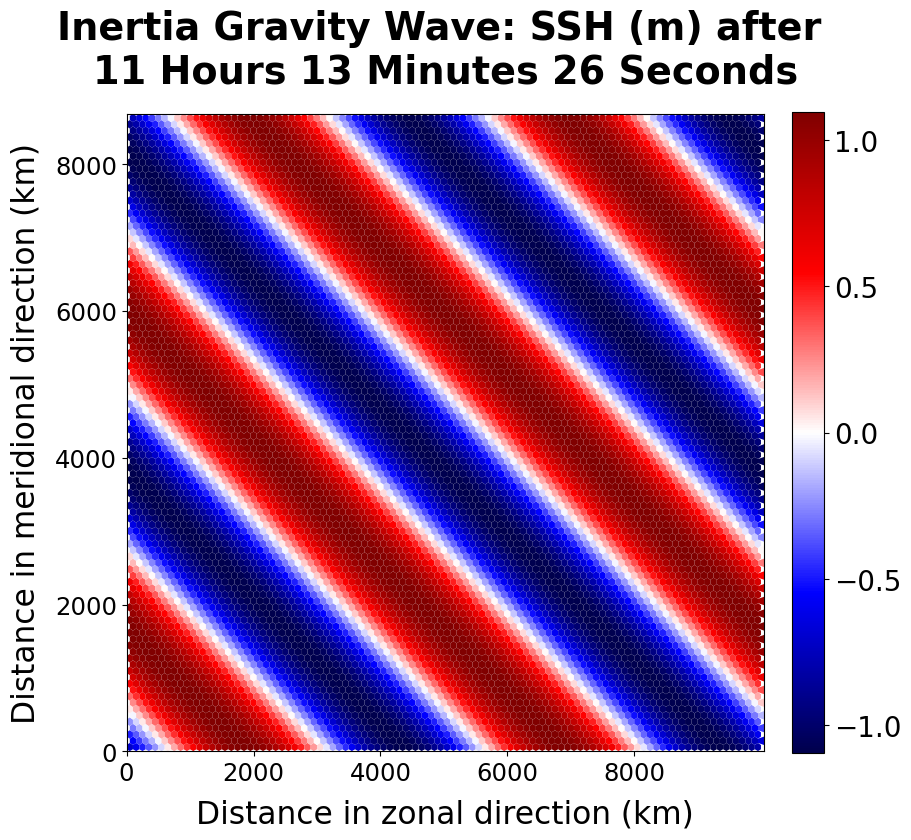

In [9]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
_, _, cbar = heatMapMesh(mpasOcean, mpasOcean.sshCurrent, fig=fig, ax=ax)

ax.set_title("Inertia Gravity Wave: SSH (m) after \n$(Int(round(hours))) Hours $(Int(round(mins))) Minutes $(Int(round(secs))) Seconds",
        fontsize=27.5, fontweight="bold", y=1.035)
# cbar.set_label("Sea Surface Elevation (mm)", fontsize=25, labelpad=7.5)
ax.set_xlabel("Distance in zonal direction (km)", fontsize=22.5, labelpad=10)
ax.set_ylabel("Distance in meridional direction (km)", fontsize=22.5, labelpad=10)
ax.tick_params(axis="both", which="major", labelsize=17.5)
cbar.ax.tick_params(labelsize=20)

xticks = Int.(round.(range(1,mpasOcean.lX,step=2e6)/1000))
ax.set_xticks(xticks*1000, xticks)
yticks = Int.(round.(range(1,mpasOcean.lY,step=2e6)/1000))
ax.set_yticks(yticks*1000, yticks)

cbar.ax.set_yticks(-1:0.5:1)

display(fig)

In [11]:
fig.savefig(CODE_ROOT * "output/inertiagravitywave/SSHsnapshot$(etaHat)_$(kX)_$(kY).pdf", bbox_inches="tight")

In [6]:
import CUDA